In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from scipy.stats import pearsonr
from collections import Counter

from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

sns.set_palette("Set2")

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, PowerTransformer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

from keras.layers import BatchNormalization

In [2]:
PATH="https://raw.githubusercontent.com/LeiteJu/TCC/main/data/csv/"

SIGLAS = ['AC', 'AL', 'AM', 'AP', 'BA', 'CE',
  'DF', 'ES', 'GO', 'MA',
  'MG', 'MS', 'MT', 'PA', 'PB',
  'PE', 'PI', 'PR', 'RJ',
  'RN', 'RO', 'RR', 'RS',
  'SC', 'SE', 'SP', 'TO']

LABELS=["subestima: -90%", "subestima entre -90% e 60%", "subestima entre -60% e -30%",
        "subestima entre -30% e 10%", "entre -10% e 10%", "superestima entre 10% e 30%", 
        "superestima entre 30% e 60%", "superestima entre 60% e 90%", "superestima mais de 90%"]

In [3]:
# calcula metricas de regressao
def score_regression_metrics(y_test, y_test_pred):

    RMSE = mean_squared_error(y_true=y_test, y_pred=y_test_pred, squared=False)
    MAE = mean_absolute_error(y_true=y_test, y_pred=y_test_pred)
    MAPE = mean_absolute_percentage_error(y_true=y_test, y_pred=y_test_pred)
    R2 = r2_score(y_true=y_test, y_pred=y_test_pred)

    scores = {
        "neg_root_mean_squared_error": RMSE,
        "neg_mean_absolute_error": MAE,
        "neg_mean_absolute_percentage_error": MAPE,
    }

    return scores

def show_scores (scores):

    print ("Scores obtidos:")

    print (f"RMSE: {scores['neg_root_mean_squared_error']}")
    print (f"MAE: {scores['neg_mean_absolute_error']}")
    print (f"MAPE: {scores['neg_mean_absolute_percentage_error']}")

In [4]:
def categorize(x):
    if x < - 0.9:
        return LABELS[0]
    elif x < - 0.6:
        return LABELS[1]
    elif x < - 0.3:
        return LABELS[2]
    elif x < - 0.1:
        return LABELS[3]
    elif x < 0.1:
        return LABELS[4]
    elif x < 0.3:
        return LABELS[5]
    elif x < 0.6:
        return LABELS[6]
    elif x < 0.9:
        return LABELS[7]
    else:
        return LABELS[8]

In [5]:
def show_delta (y_test, y_pred):
    
    data=(y_pred - y_test)/y_test

    error = pd.DataFrame(data, columns=['erro'])
    error['categoria']=error['erro'].apply(categorize)
    
    plt.figure(figsize=(28,6))

    sns.countplot(data=error, x='categoria', order=LABELS)

    plt.show()

In [6]:
def show_predictions_graphs (data):

    plt.figure(figsize=(24,45))

    for state in range(27):

        plt.subplot(9,3,state+1)
        
        plt.yscale('linear')

        plt.title (f"Distribuição do erro do estado {SIGLAS[state]}")

        # pred = y_pred[state]
        # real = y_test[state]

        plt.plot(pd.DataFrame(data[SIGLAS[state]]["y_pred"]), label="Previsão", color="coral")
        plt.plot(pd.DataFrame(data[SIGLAS[state]]["y_test"]), label="Dado Real", linestyle=":",color="darkgreen")

        plt.legend()
    plt.show()

In [7]:
def split_y_state (y):

    if type(y) == np.ndarray:

        return dict(zip([i for i in range(27)], [[y[i] for i in range(s, len(y), 27)] for s in range(27)]))

    return dict(zip([i for i in range(27)], [[y.iloc[i] for i in range(s, y.size, 27)] for s in range(27)]))

# Modelos

In [111]:
x = pd.read_csv("../dados/input/input.csv")
x=x.sort_values(["data", "estados"])
x = pd.get_dummies(data=x, columns=["estados"], drop_first=True)
x=x[(x["data"] >= "1991-01-01") & (x["data"] <= "2018-12-01")]
x = x.drop(["data"], axis=1)

In [112]:
PATH="https://raw.githubusercontent.com/LeiteJu/TCC/main/data/csv/"
y = pd.read_csv(PATH + "target_abs.csv")
y = pd.melt(y,id_vars=["data"], value_vars=SIGLAS, var_name="estados", value_name="consumo")
y = y.sort_values(['data', 'estados'])
y=y[(y["data"] > 199112)]['consumo']

In [113]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100)

Epoch 1/100
241/241 [==============================] - 1s 2ms/step - loss: 55311826944.0000 - RMSE: 235184.6719
Epoch 2/100
241/241 [==============================] - 0s 2ms/step - loss: 20007198720.0000 - RMSE: 141446.8125
Epoch 3/100
241/241 [==============================] - 0s 2ms/step - loss: 3768461824.0000 - RMSE: 61387.7969
Epoch 4/100
241/241 [==============================] - 0s 1ms/step - loss: 2297743360.0000 - RMSE: 47934.7812
Epoch 5/100
241/241 [==============================] - 0s 1ms/step - loss: 2023098624.0000 - RMSE: 44978.8672
Epoch 6/100
241/241 [==============================] - 0s 1ms/step - loss: 1716544640.0000 - RMSE: 41431.2031
Epoch 7/100
241/241 [==============================] - 0s 1ms/step - loss: 1787884672.0000 - RMSE: 42283.3867
Epoch 8/100
241/241 [==============================] - 0s 1ms/step - loss: 1638451328.0000 - RMSE: 40477.7891
Epoch 9/100
241/241 [==============================] - 0s 1ms/step - loss: 1735104128.0000 - RMSE: 41654.5820
Epoch 

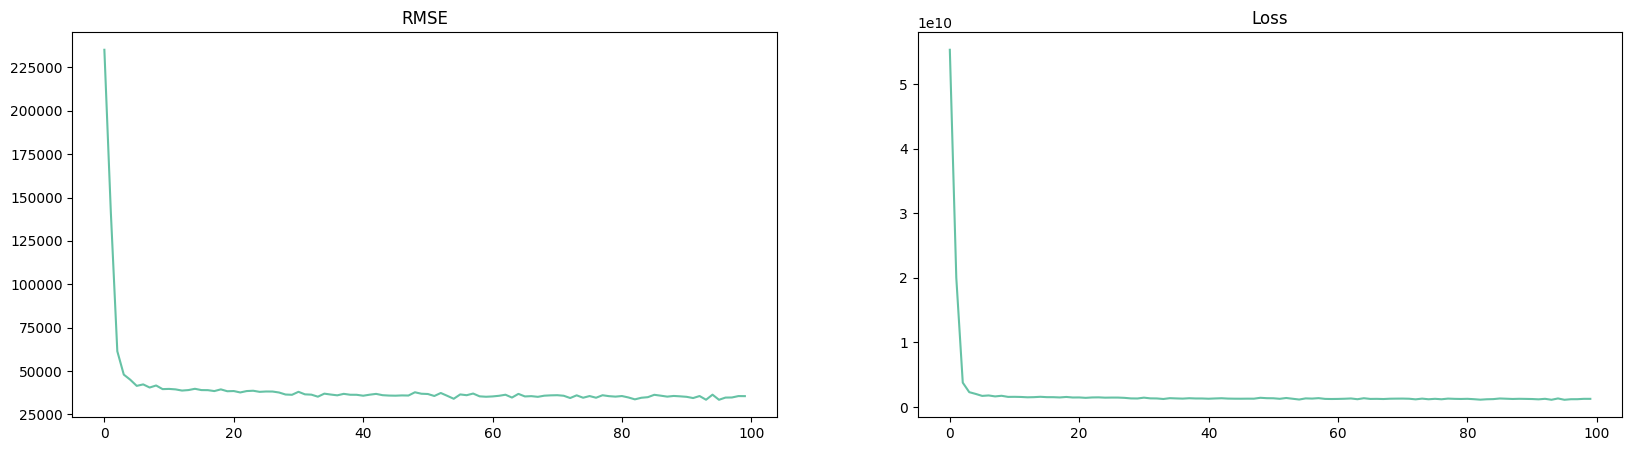

In [114]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)

plt.plot(history.history["RMSE"])
plt.title("RMSE")

plt.subplot(1,2,2)

plt.plot(history.history["loss"])
plt.title("Loss")

plt.show()

In [115]:
y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

43/43 [==============================] - 0s 998us/step
Scores obtidos:
RMSE: 103484.26112881998
MAE: 69888.36819922162
MAPE: 0.9365078835914098


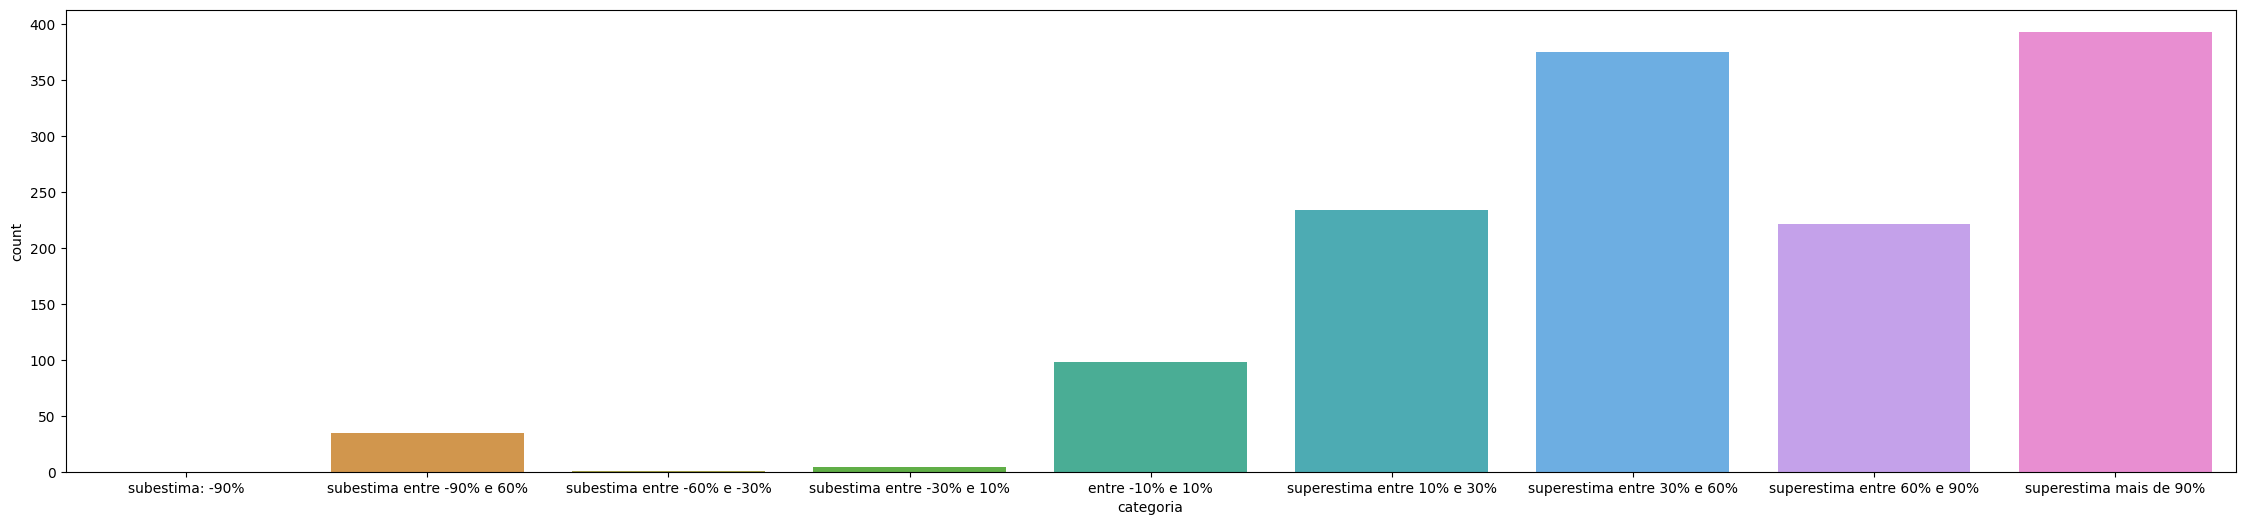

In [116]:
show_delta(np.array(y_test), y_pred.flatten())

In [117]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100)

Epoch 1/100
241/241 [==============================] - 1s 1ms/step - loss: 56659312640.0000 - RMSE: 238032.1719
Epoch 2/100
241/241 [==============================] - 0s 2ms/step - loss: 37583548416.0000 - RMSE: 193864.7656
Epoch 3/100
241/241 [==============================] - 0s 2ms/step - loss: 21524647936.0000 - RMSE: 146712.8125
Epoch 4/100
241/241 [==============================] - 0s 2ms/step - loss: 13673297920.0000 - RMSE: 116932.8750
Epoch 5/100
241/241 [==============================] - 0s 2ms/step - loss: 6821530624.0000 - RMSE: 82592.5547
Epoch 6/100
241/241 [==============================] - 0s 2ms/step - loss: 3555687168.0000 - RMSE: 59629.5820
Epoch 7/100
241/241 [==============================] - 0s 2ms/step - loss: 2339043584.0000 - RMSE: 48363.6602
Epoch 8/100
241/241 [==============================] - 0s 2ms/step - loss: 2019715584.0000 - RMSE: 44941.2461
Epoch 9/100
241/241 [==============================] - 0s 2ms/step - loss: 1966609664.0000 - RMSE: 44346.4727
Ep

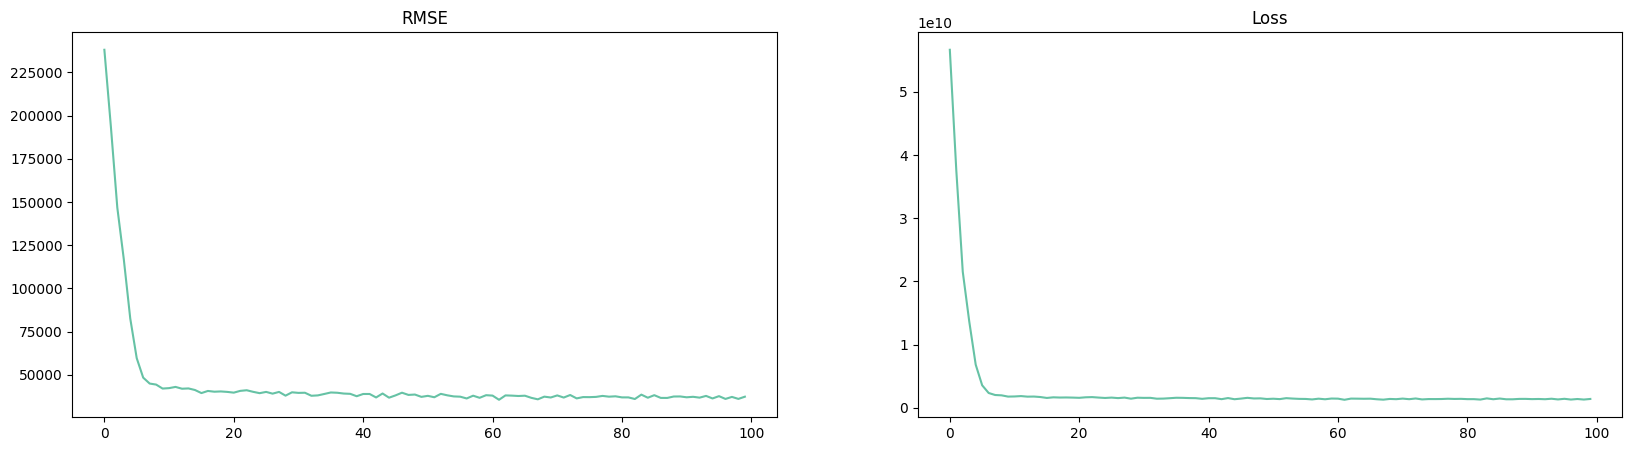

In [118]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)

plt.plot(history.history["RMSE"])
plt.title("RMSE")

plt.subplot(1,2,2)

plt.plot(history.history["loss"])
plt.title("Loss")

plt.show()

In [119]:
y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

43/43 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 112537.81292023466
MAE: 69454.93993100202
MAPE: 0.8291124474729308


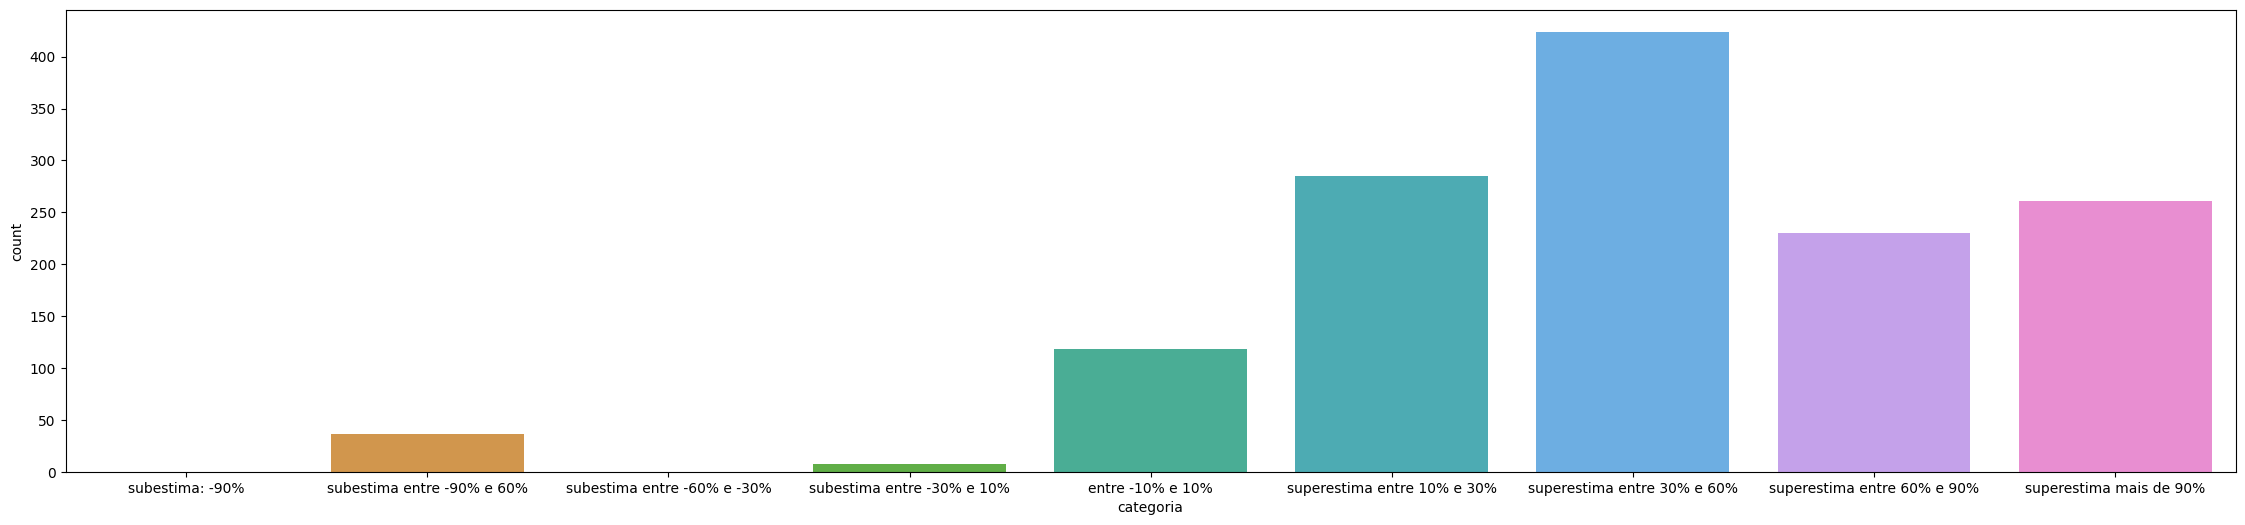

In [120]:
show_delta(np.array(y_test), y_pred.flatten())

In [121]:
len(y_test) % 27

11

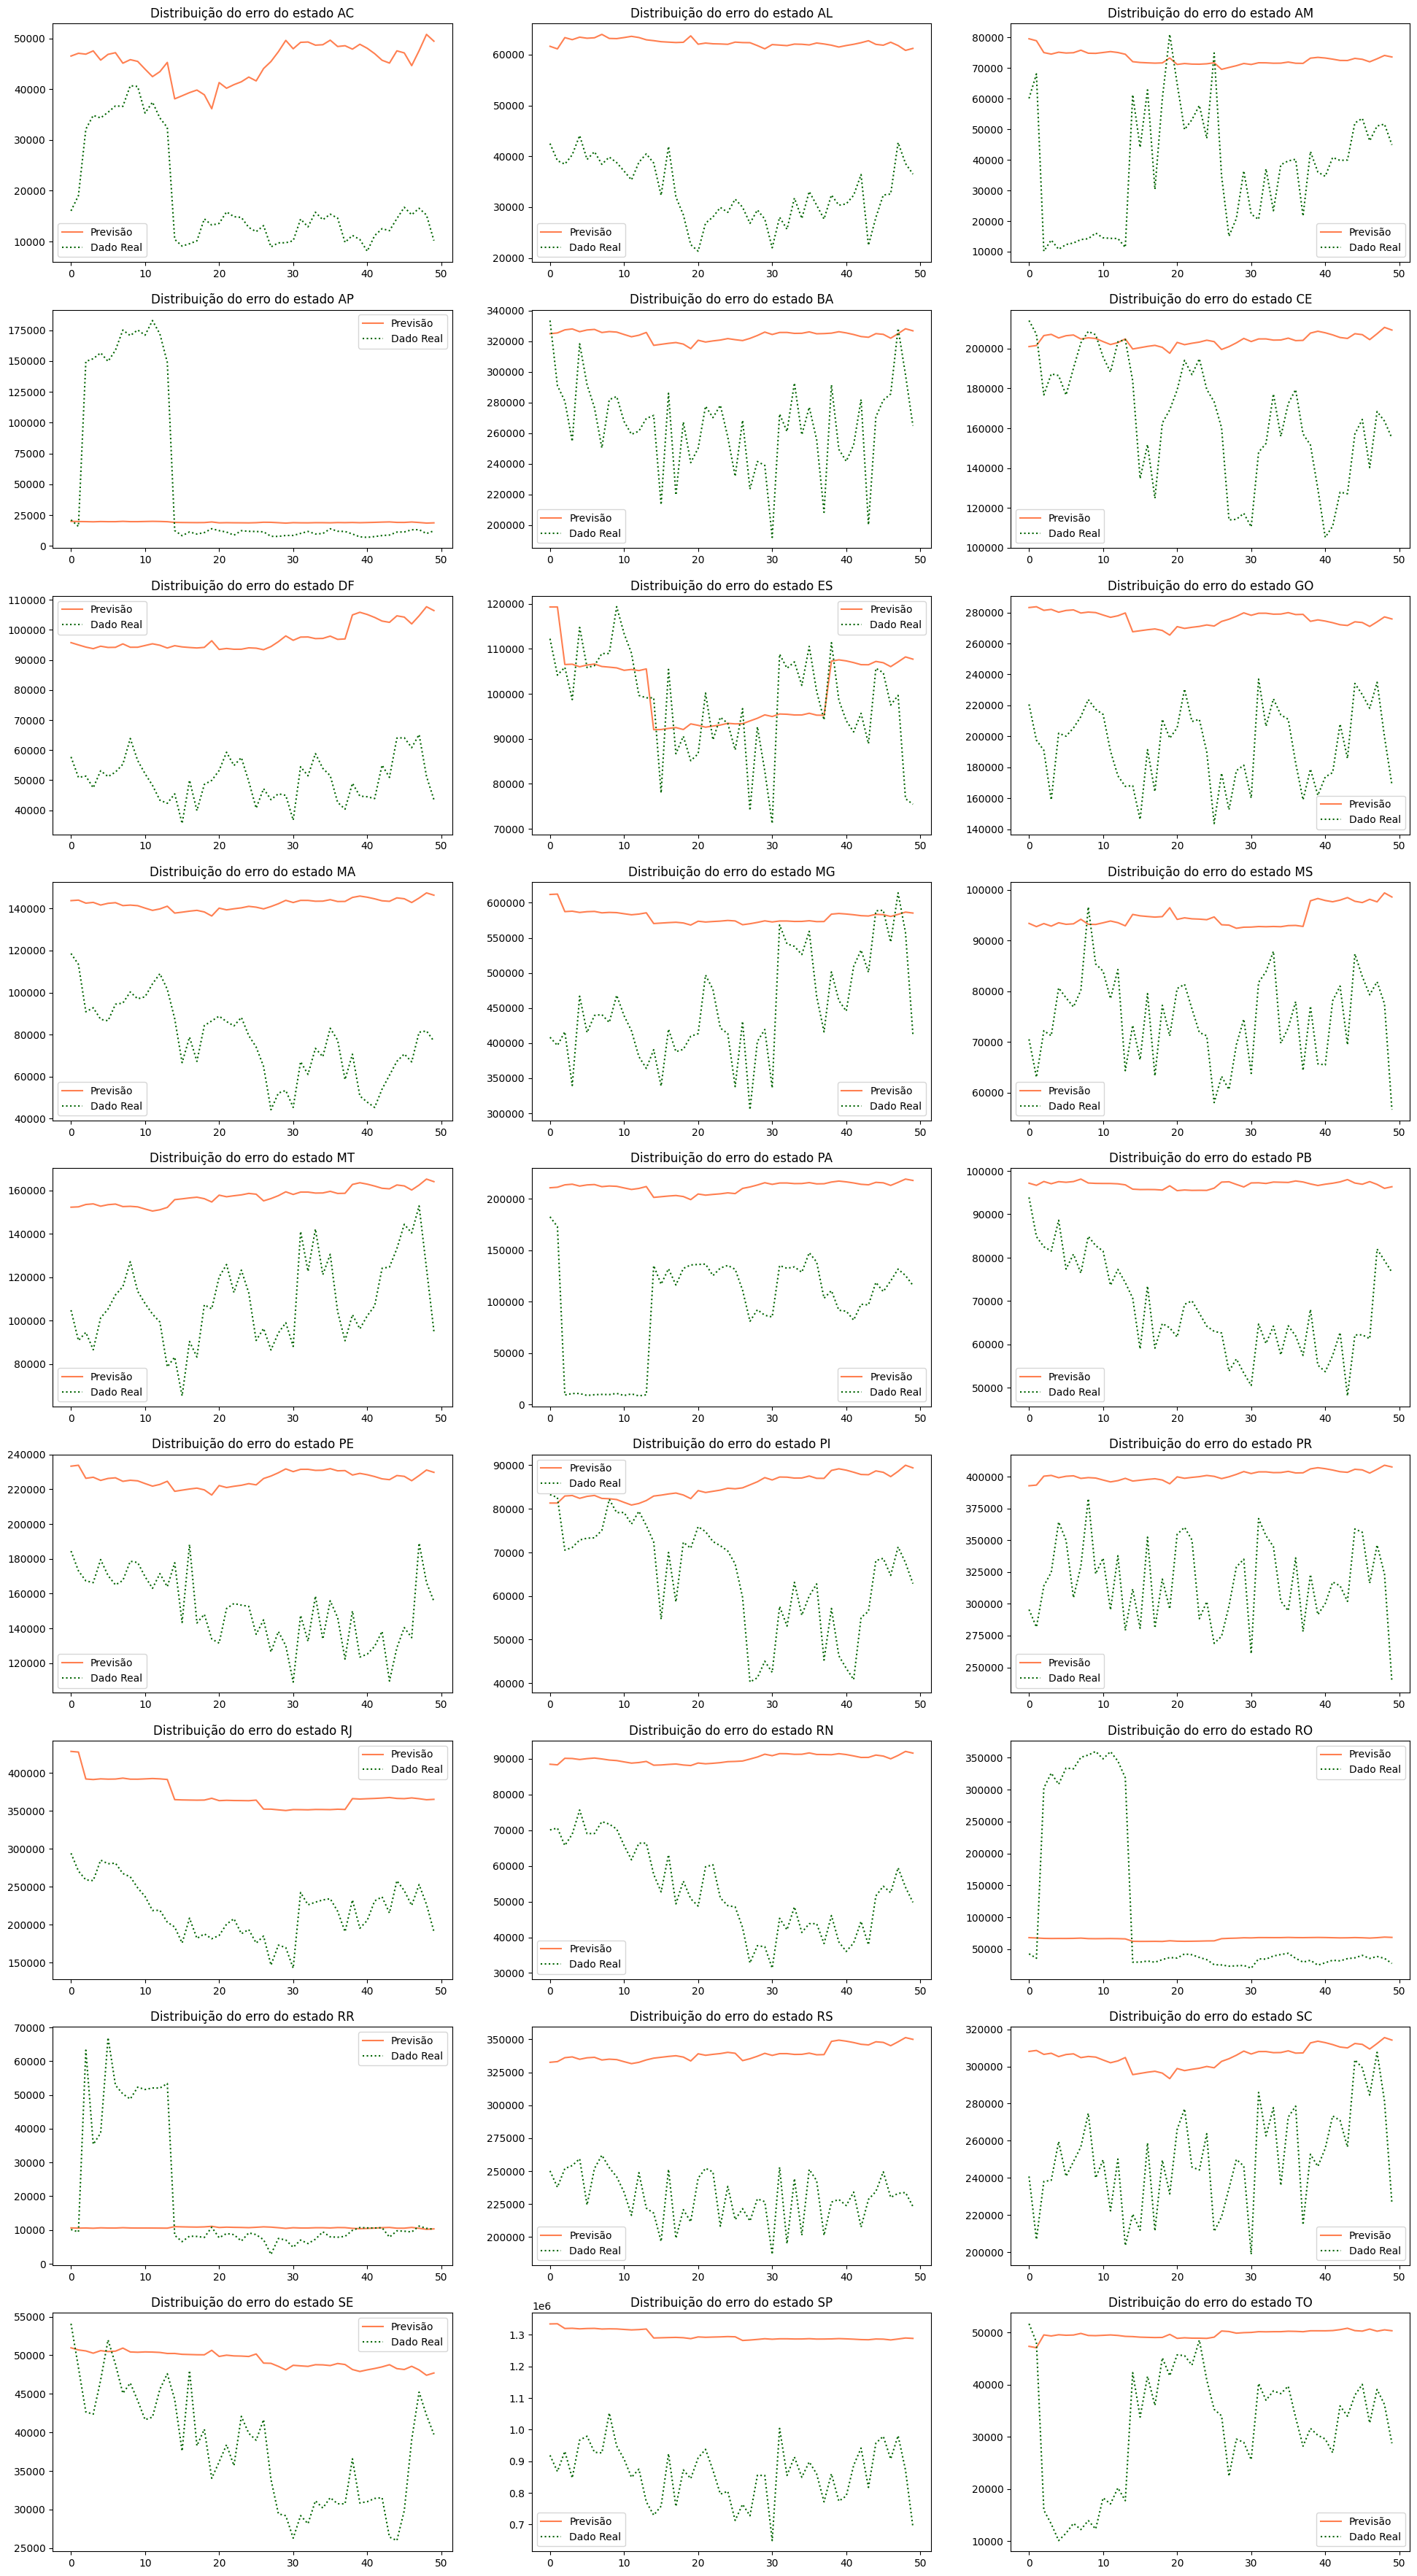

In [122]:
y_pred = y_pred[11:]
y_test = y_test[11:]

y_pred_state = split_y_state(y_pred)
y_test_state = split_y_state(y_test)

pred = {}

for i in range(27):
    pred[SIGLAS[i]] = {"y_test":y_test_state[i],
                       "y_pred":y_pred_state[i]}
show_predictions_graphs(pred)

In [123]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

scaler = PowerTransformer()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),
model.add(Dense(units=16, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100)

Epoch 1/100
241/241 [==============================] - 1s 2ms/step - loss: 49753993216.0000 - RMSE: 223056.0312
Epoch 2/100
241/241 [==============================] - 0s 1ms/step - loss: 8614539264.0000 - RMSE: 92814.5391
Epoch 3/100
241/241 [==============================] - 0s 2ms/step - loss: 3456812288.0000 - RMSE: 58794.6602
Epoch 4/100
241/241 [==============================] - 0s 2ms/step - loss: 2519956992.0000 - RMSE: 50199.1719
Epoch 5/100
241/241 [==============================] - 1s 3ms/step - loss: 2207012608.0000 - RMSE: 46978.8516
Epoch 6/100
241/241 [==============================] - 1s 3ms/step - loss: 2398916352.0000 - RMSE: 48978.7344
Epoch 7/100
241/241 [==============================] - 1s 3ms/step - loss: 2013805696.0000 - RMSE: 44875.4453
Epoch 8/100
241/241 [==============================] - 1s 3ms/step - loss: 2045137920.0000 - RMSE: 45223.1992
Epoch 9/100
241/241 [==============================] - 1s 3ms/step - loss: 2169353728.0000 - RMSE: 46576.3203
Epoch 10

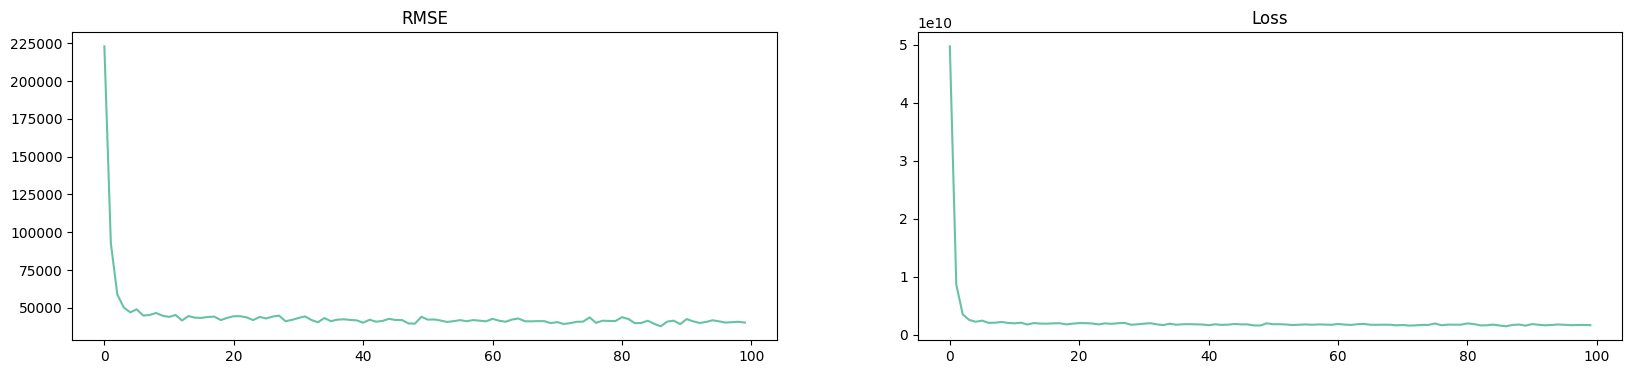

In [124]:
plt.figure(figsize=(20,4))

plt.subplot(1,2,1)

plt.plot(history.history["RMSE"])
plt.title("RMSE")

plt.subplot(1,2,2)

plt.plot(history.history["loss"])
plt.title("Loss")

plt.show()

In [125]:
show_scores(score_regression_metrics(y_train, model.predict(x_train)))
y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

241/241 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 27919.783739573424
MAE: 14009.315700548126
MAPE: 3093401817938485.0
43/43 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 91937.0683363055
MAE: 62986.67700966661
MAPE: 0.8480527244544965


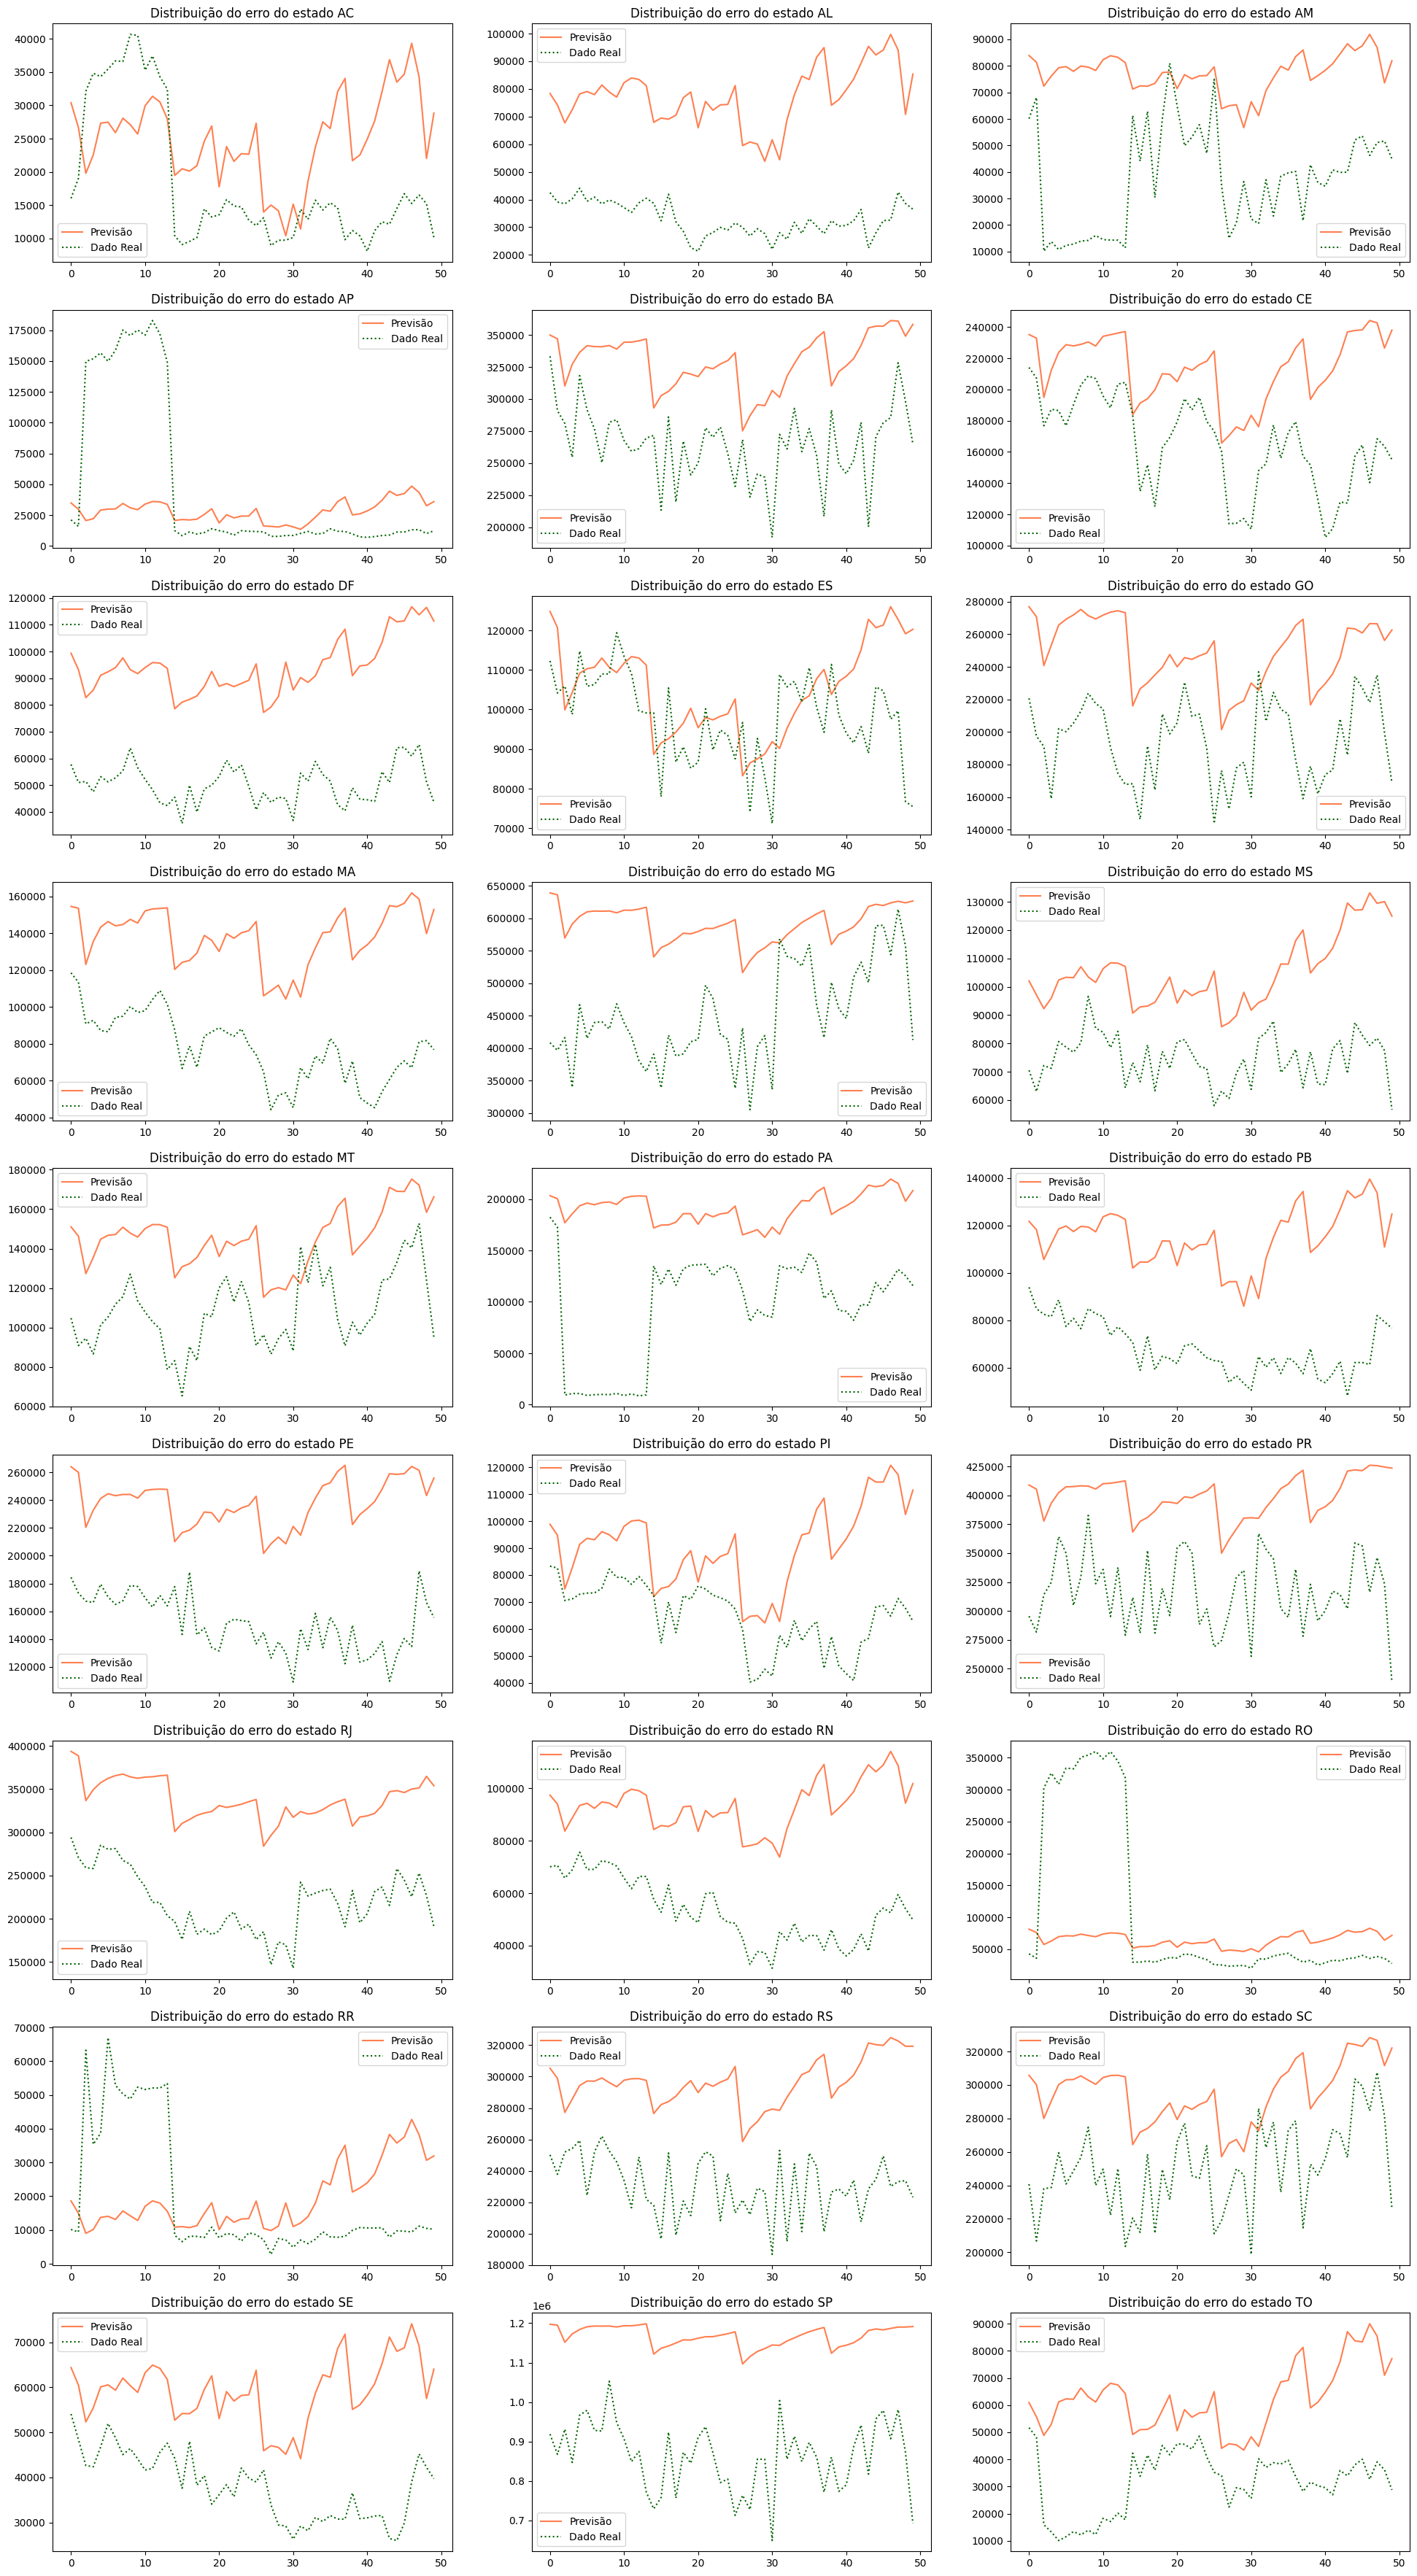

In [126]:
y_pred = y_pred[11:]
y_test = y_test[11:]

y_pred_state = split_y_state(y_pred)
y_test_state = split_y_state(y_test)

pred = {}

for i in range(27):
    pred[SIGLAS[i]] = {"y_test":y_test_state[i],
                       "y_pred":y_pred_state[i]}
show_predictions_graphs(pred)

## LSTM

In [127]:
# n_steps -> timestep no tempo .. pegar contexto
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [128]:
class StandardScaler3DShape:
    def __init__(self, scaler=StandardScaler):
        self.scaler = scaler() #StandardScaler()

    def fit_transform(self, X, y=None):
        X_new = self.scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
        return X_new

    def fit(self, X, y=None):
        X_new = X.reshape(-1, X.shape[-1])
        self.scaler.fit(X_new)
        return self

    def transform(self, X, y=None):
        X_new = self.scaler.transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
        return X_new

In [162]:
x = pd.read_csv("../dados/input/input.csv")
x=x.sort_values(["data", "estados"])
x = pd.get_dummies(data=x, columns=["estados"], drop_first=True)
x=x[(x["data"] >= "1999-01-01") & (x["data"] <= "2018-12-01")]
#x = x.drop(["data"], axis=1)

PATH="https://raw.githubusercontent.com/LeiteJu/TCC/main/data/csv/"
y = pd.read_csv(PATH + "target_abs.csv")
y = pd.melt(y,id_vars=["data"], value_vars=SIGLAS, var_name="estados", value_name="consumo")
y = y.sort_values(['data', 'estados'])
y=y[(y["data"] > 199912)]

df = x.copy()
df["consumo"] = y["consumo"].values

In [168]:
df = df.drop("data", axis=1)

In [169]:
df_train, df_test = train_test_split(df, test_size=0.15, shuffle=False)

timesteps=3
scaler = StandardScaler3DShape()
x_train,y_train = split_sequences(df_train.values, timesteps)
x_test,y_test = split_sequences(df_test.values, timesteps)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [170]:
model = Sequential()
model.add(LSTM(units=32, activation="relu")),
model.add(Dense(units=16, activation="relu")),
model.add(Dense(units=8, activation="relu")),
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])

In [171]:
history = model.fit(x_train, y_train, epochs=100, batch_size=32) 

Epoch 1/100
173/173 [==============================] - 5s 8ms/step - loss: 66917728256.0000 - RMSE: 258684.6094
Epoch 2/100
173/173 [==============================] - 1s 8ms/step - loss: 35481542656.0000 - RMSE: 188365.4531
Epoch 3/100
173/173 [==============================] - 1s 9ms/step - loss: 7457144320.0000 - RMSE: 86354.7578
Epoch 4/100
173/173 [==============================] - 2s 9ms/step - loss: 4082688000.0000 - RMSE: 63895.9141
Epoch 5/100
173/173 [==============================] - 1s 8ms/step - loss: 3443155712.0000 - RMSE: 58678.4102
Epoch 6/100
173/173 [==============================] - 1s 8ms/step - loss: 3288553984.0000 - RMSE: 57345.9141
Epoch 7/100
173/173 [==============================] - 1s 7ms/step - loss: 3199350528.0000 - RMSE: 56562.8008
Epoch 8/100
173/173 [==============================] - 1s 8ms/step - loss: 3014379520.0000 - RMSE: 54903.3672
Epoch 9/100
173/173 [==============================] - 1s 8ms/step - loss: 2945737472.0000 - RMSE: 54274.6484
Epoch 

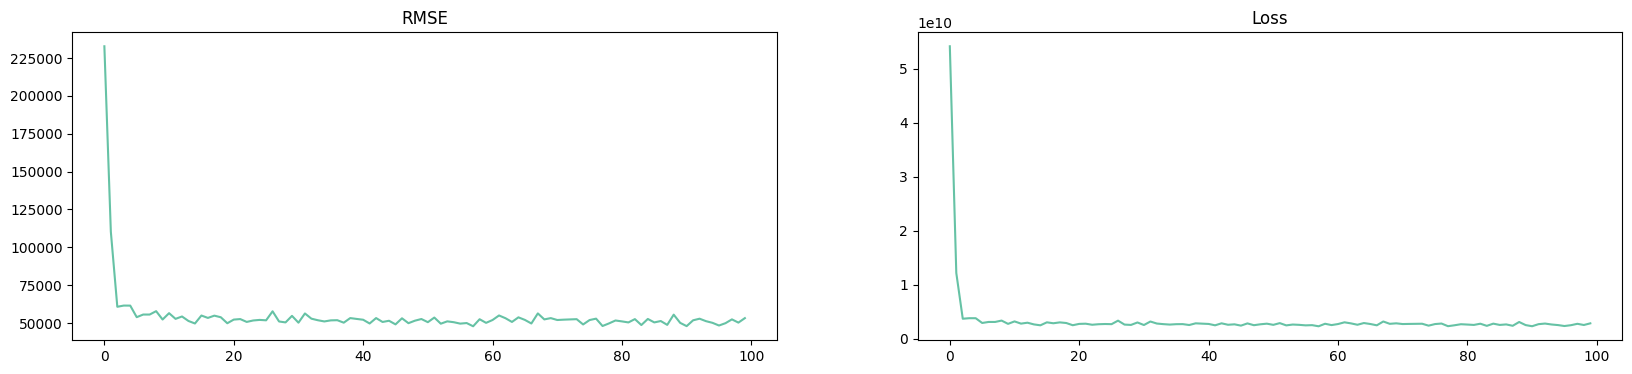

In [145]:
plt.figure(figsize=(20,4))

plt.subplot(1,2,1)

plt.plot(history.history["RMSE"])
plt.title("RMSE")

plt.subplot(1,2,2)

plt.plot(history.history["loss"])
plt.title("Loss")

plt.show()

In [172]:
show_scores(score_regression_metrics(y_train, model.predict(x_train)))
y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

173/173 [==============================] - 1s 5ms/step
Scores obtidos:
RMSE: 22746.292133886473
MAE: 13099.315300911081
MAPE: 0.19320063537692125
31/31 [==============================] - 0s 5ms/step
Scores obtidos:
RMSE: 72577.07444833496
MAE: 43242.58325950387
MAPE: 0.8207355569338802


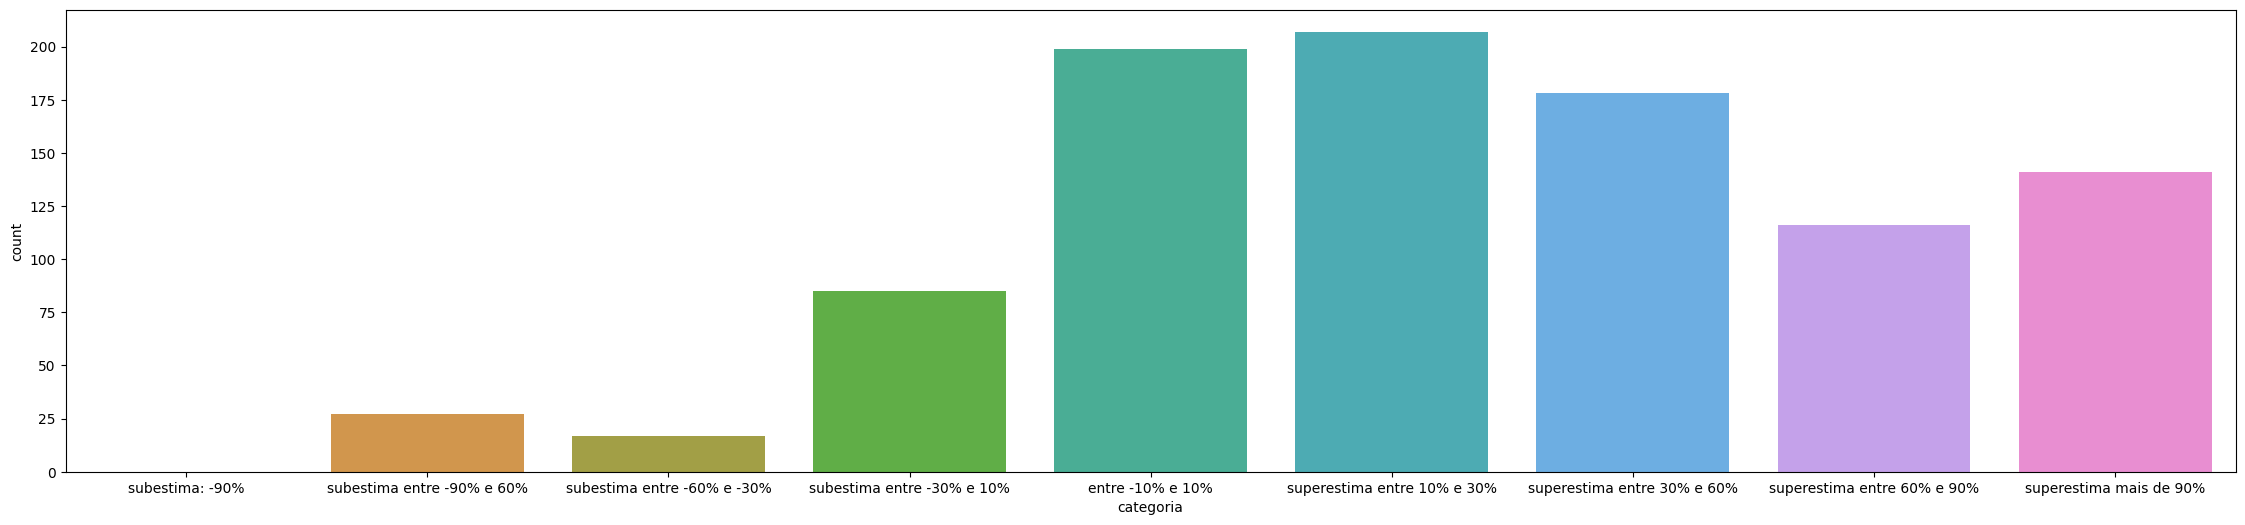

In [173]:
show_delta(np.array(y_test), y_pred.flatten())

In [ ]:
## show_scores(score_regression_metrics(y_train, model.predict(x_train)))
y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

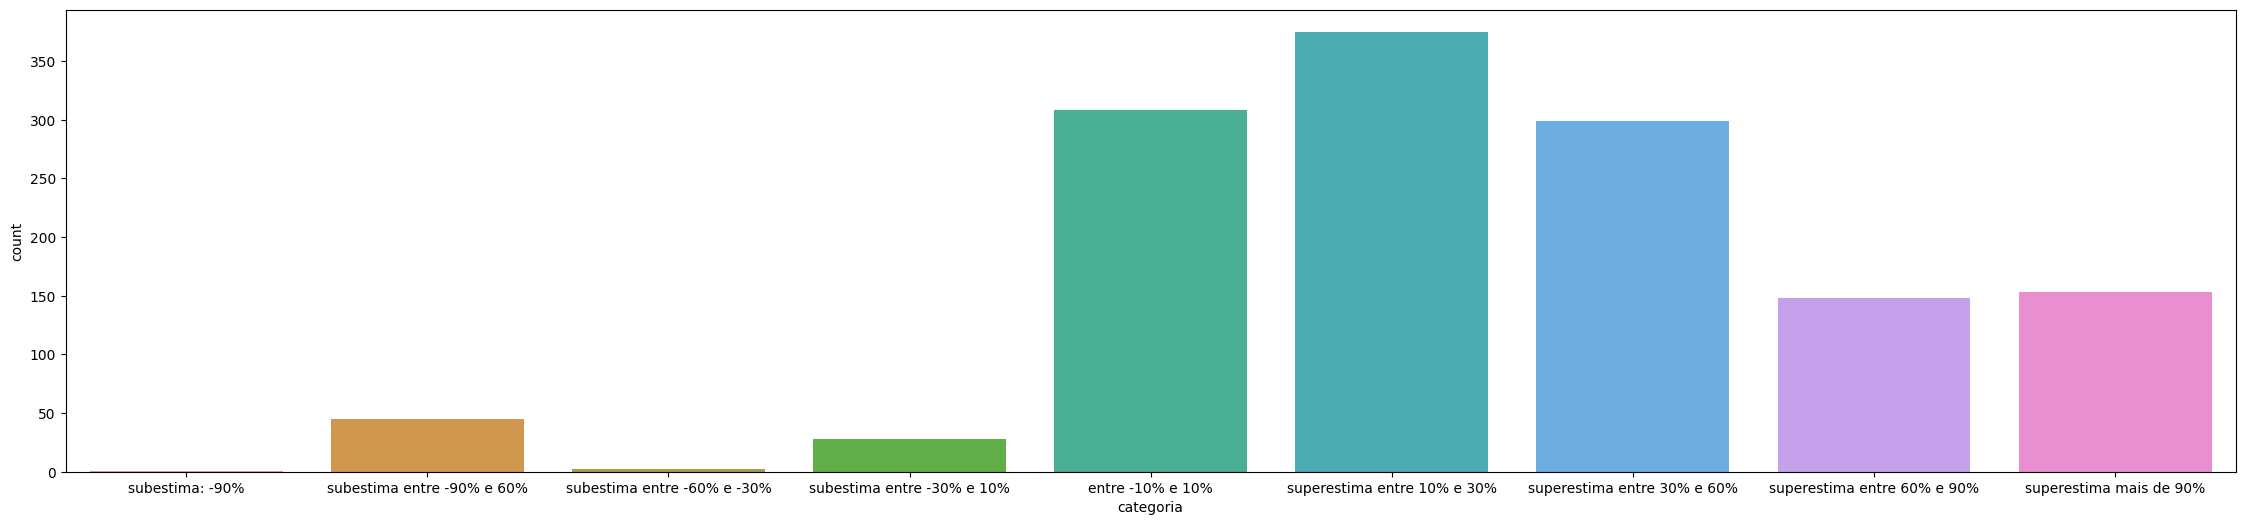

In [147]:
show_delta(np.array(y_test), y_pred.flatten())

In [151]:
y = pd.read_csv(PATH + "target_abs.csv")
y = pd.melt(y,id_vars=["data"], value_vars=SIGLAS, var_name="estados", value_name="consumo")
y = y.sort_values(['data', 'estados'])

In [154]:
y[y["consumo"] == 0]

,data,estados,consumo
3,199004,AC,0.0
7583,199112,RR,0.0
7585,199202,RR,0.0
7588,199205,RR,0.0
7608,199401,RR,0.0
7609,199402,RR,0.0
7620,199501,RR,0.0
